In [48]:
import requests
import os
import pandas as pd
import plotly as ply
import statsmodels.tsa.stattools as sm_stattools
import statsmodels.stats.diagnostic as sm_diagnostic
import statsmodels.tsa.vector_ar.vecm as sm_vecm
import statsmodels.tsa.api as sm_api
from scipy import stats
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import io
import warnings
import statistics

files = os.listdir(".")
if "data" not in files:
	os.chdir("..")


def join_working_data_on_date(name):
	"""
		Joins all data in the data/source folder into a single data table and
		saves the result
	"""
	working_data = None
	target_path = "./data/target/{}.csv".format(name)
	source_path = "./data/source/{}/".format(name)

	if(not os.path.exists(target_path)):
		files = os.listdir(source_path)
		flag = False
		for file in files:
			if file == ".DS_Store":
				continue
			file_path = source_path + file

			other_data = pd.read_csv(file_path, index_col= "DATE", na_values=".")
			other_data = other_data.sort_index().fillna(method='pad')
			if (flag == False):
				working_data = other_data
				flag = True
			else:
				working_data = pd.DataFrame.merge(
					working_data,
					other_data,
					on='DATE',
					how='inner'
					)
		working_data.to_csv(target_path)
	else:
		working_data = pd.read_csv(target_path, index_col= "DATE")


	return working_data

def check_stationarity(input_df):
	sm_stattools.adfuller(input_df)

def granger_test(input_df):
	sm_stattools.grangercausalitytests()

In [3]:
working_df = join_working_data_on_date("commodities")
working_df = working_df.rename(
	{ "POILBREUSDM": "oil",
		"GOLDAMGBD228NLBM": "gold",
		"FEDFUNDS": "interest",
		"WILL5000PRFC": "market",
		"UNRATE": "unemp"

}, axis=1)
working_df = working_df.sort_index()
working_df.isnull().sum() 

oil          0
gold        31
unemp        0
interest     0
market      29
dtype: int64

In [4]:

working_df = working_df.fillna(method='pad')
working_df.isnull().sum()

oil         0
gold        1
unemp       0
interest    0
market      1
dtype: int64

In [5]:
working_df = working_df.dropna()
working_df

,oil,gold,unemp,interest,market
DATE,,,,,
1990-02-01,19.930000,413.25,5.3,8.24,3166.40
1990-03-01,18.370000,406.25,5.2,8.28,3210.98
1990-05-01,16.340000,368.95,5.4,8.18,3185.44
1990-06-01,15.050000,363.10,5.2,8.29,3467.97
1990-08-01,27.320000,371.10,5.7,8.13,3377.80
...,...,...,...,...,...
2021-02-01,61.963500,1857.80,6.2,0.08,40076.90
2021-03-01,65.186957,1746.95,6.0,0.07,41538.33
2021-04-01,64.770000,1715.85,6.1,0.07,42280.97


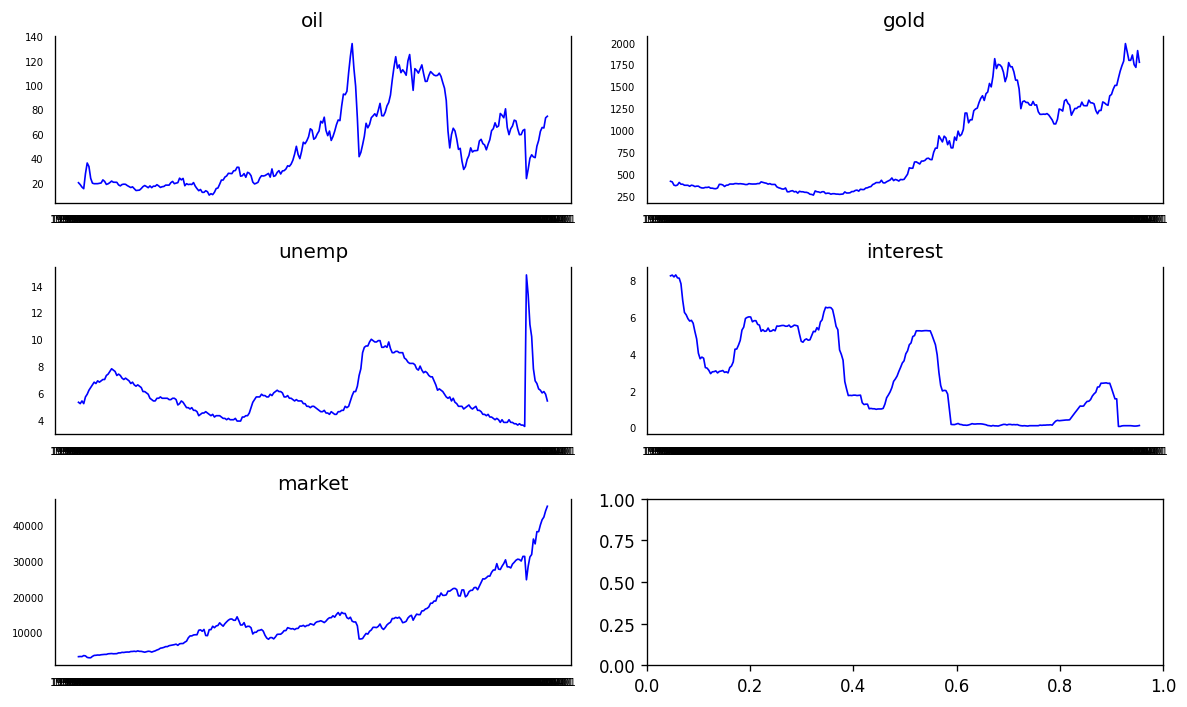

In [6]:
### Plots
fig, axes = plt.subplots(nrows=3, ncols=2, dpi = 120, figsize = (10,6))
for index, ax in enumerate(axes.flatten()):
	if index >= len(working_df.columns): 
		continue
	data = working_df[working_df.columns[index]]
	ax.plot(data, color = 'blue', linewidth = 1)
	ax.set_title(working_df.columns[index])
	ax.xaxis.set_ticks_position('none')
	ax.yaxis.set_ticks_position('none')
	ax.spines['top'].set_alpha(0)
	ax.tick_params(labelsize = 6)

plt.tight_layout()

In [7]:

# A-DF test H0: unit root (non-stationarity)

for column in working_df.columns:
	stationarity_result = sm_stattools.adfuller(working_df[column])
	stationarity_stat, stationarity_pval =\
		[stationarity_result[0], stationarity_result[1]]
	stationarity_pval = round(stationarity_pval, 5)
	print("{} ADF pvalue: {}".format(column, stationarity_pval))



oil ADF pvalue: 0.32216
gold ADF pvalue: 0.92519
unemp ADF pvalue: 0.00747
interest ADF pvalue: 0.06447
market ADF pvalue: 1.0


In [8]:
first_difference = working_df.diff().dropna()

print("1st Difference")
for column in first_difference.columns:
	stationarity_result = sm_stattools.adfuller(first_difference[column])
	stationarity_stat, stationarity_pval =\
		[stationarity_result[0], stationarity_result[1]]
	stationarity_pval = round(stationarity_pval, 5)
	print("{} ADF pvalue: {}".format(column, stationarity_pval))


1st Difference
oil ADF pvalue: 0.0
gold ADF pvalue: 0.00269
unemp ADF pvalue: 0.0
interest ADF pvalue: 0.0
market ADF pvalue: 0.00136


In [9]:
johansen_test_df = working_df.drop('unemp', axis = 1)
johansen_result = sm_vecm.coint_johansen(johansen_test_df, 0, 1)

print("Johansen Trace Test statistics")
print(johansen_test_df.columns.values)
print(johansen_result.lr1)
cvt_result = [item[0] for item in johansen_result.cvt]
print("Critical values for alpha = 0.05")
print(cvt_result)


Johansen Trace Test statistics
['oil' 'gold' 'interest' 'market']
[56.5009255  19.51128626  6.98079111  0.46019707]
Critical values for alpha = 0.05
[44.4929, 27.0669, 13.4294, 2.7055]


In [10]:
first_difference_rn = first_difference.rename(lambda x: x + "_diff_1", axis = 1)
stationary_df = first_difference_rn.drop('unemp_diff_1', axis = 1)
stationary_df['unemp'] = working_df['unemp']
for column in stationary_df.columns:
	norm_stat, norm_crit, norm_sigs = stats.anderson(stationary_df[column])
	norm_crit = round(norm_crit[2], 5)
	norm_stat = round(norm_stat, 5)
	print("{} normal stat, critical val : {}, {}".format(column, norm_stat, norm_crit))
	


oil_diff_1 normal stat, critical val : 9.42906, 0.776
gold_diff_1 normal stat, critical val : 14.77303, 0.776
interest_diff_1 normal stat, critical val : 21.01335, 0.776
market_diff_1 normal stat, critical val : 12.84694, 0.776
unemp normal stat, critical val : 7.26976, 0.776


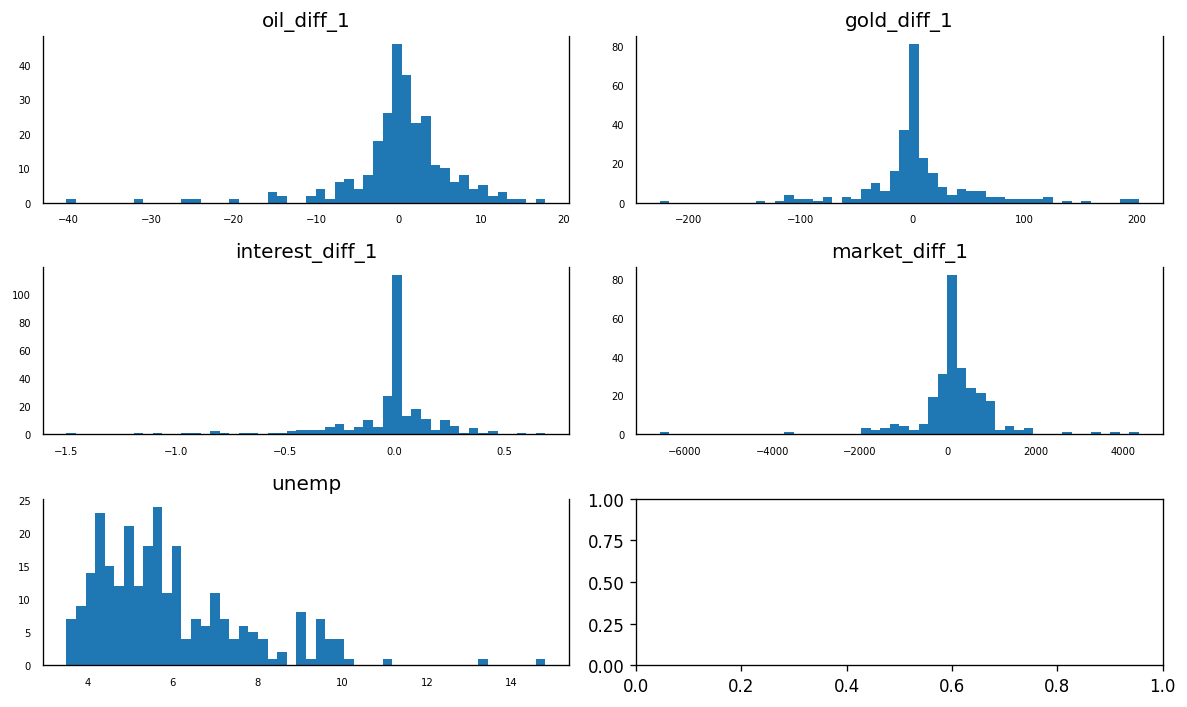

In [11]:

fig, axes = plt.subplots(nrows=3, ncols=2, dpi = 120, figsize = (10,6))
for index, ax in enumerate(axes.flatten()):
	if index >= len(stationary_df.columns): 
		continue
	data = stationary_df[stationary_df.columns[index]]
	ax.hist(data, bins=50)
	ax.set_title(stationary_df.columns[index])
	ax.xaxis.set_ticks_position('none')
	ax.yaxis.set_ticks_position('none')
	ax.spines['top'].set_alpha(0)
	ax.tick_params(labelsize = 6)

plt.tight_layout()

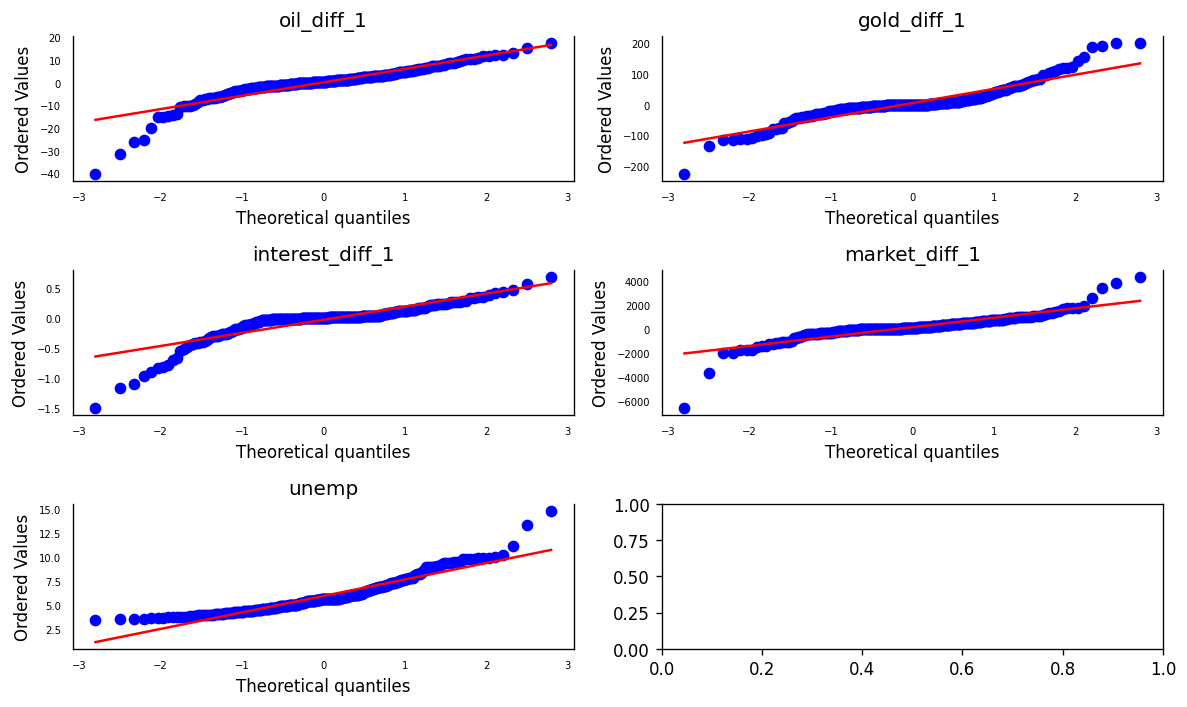

In [12]:
fig, axes = plt.subplots(nrows=3, ncols=2, dpi = 120, figsize = (10,6))
for index, ax in enumerate(axes.flatten()):
	if index >= len(stationary_df.columns): 
		continue
	data = stationary_df[stationary_df.columns[index]]
	stats.probplot(data, plot = ax)
	ax.set_title(stationary_df.columns[index])
	ax.xaxis.set_ticks_position('none')
	ax.yaxis.set_ticks_position('none')
	ax.spines['top'].set_alpha(0)
	ax.tick_params(labelsize = 6)

plt.tight_layout()

In [13]:
for column in stationary_df.columns:
	skew_result = stats.skew(stationary_df[column])
	kurtosis_result = stats.kurtosis(stationary_df[[column]])
	skew_result = round(skew_result, 3)
	kurtosis_result = round(kurtosis_result[0], 3)
	print("{} \n|\t skew, kurtosis: {}, {}".format(column, skew_result, kurtosis_result))

oil_diff_1 
|	 skew, kurtosis: -1.933, 9.287
gold_diff_1 
|	 skew, kurtosis: 0.531, 4.739
interest_diff_1 
|	 skew, kurtosis: -2.138, 8.537
market_diff_1 
|	 skew, kurtosis: -1.216, 16.391
unemp 
|	 skew, kurtosis: 1.345, 2.47


In [14]:
stationary_df = stationary_df.dropna()
for column in stationary_df.columns:
	if column == "gold_diff_1":
		continue
	test_frame = pd.DataFrame([stationary_df["gold_diff_1"].values, stationary_df[column].values]).transpose()
	granger_result_tmp = sm_stattools.grangercausalitytests(
		test_frame, 3, verbose = False)
	granger_result = {}
	for key,value in granger_result_tmp.items():
		granger_result[key] = round(granger_result_tmp[key][0]['ssr_ftest'][1], 3)
		
	print("{} \n|\t granger result (lag: pval) ... {}".format(column, granger_result))

print()


oil_diff_1 
|	 granger result (lag: pval) ... {1: 0.067, 2: 0.071, 3: 0.159}
interest_diff_1 
|	 granger result (lag: pval) ... {1: 0.963, 2: 0.604, 3: 0.772}
market_diff_1 
|	 granger result (lag: pval) ... {1: 0.432, 2: 0.667, 3: 0.782}
unemp 
|	 granger result (lag: pval) ... {1: 0.026, 2: 0.027, 3: 0.075}



In [73]:
warnings.filterwarnings("ignore")

var_df = stationary_df

loss_list_1 = []
loss_list_2 = []
for index_offset in range(100):
	initial_index = -(102 - index_offset)
	train_dataset = var_df[:initial_index]
	model = sm_api.VAR(train_dataset)
	fitted_model = model.fit(maxlags = 10, ic = 'bic')
	lag_order = fitted_model.k_ar
	forecast_tmp = fitted_model.forecast(train_dataset[-lag_order:].values, 1)
	forcasted_val = forecast_tmp[0][list(var_df.columns.values).index( 'gold_diff_1')]
	actual_val = var_df['gold_diff_1'][initial_index]
	if (forcasted_val * actual_val > 0) or\
		(abs(forcasted_val) < 0.1 and abs(actual_val) < 0.1):
		loss_list_1.append(1)
	else:
		loss_list_1.append(0)
	
	relative_distance = 0
	if actual_val > 1e-5:
		relative_distance = abs((actual_val - forcasted_val) / actual_val)
	else:
		relative_distance = abs(actual_val - forcasted_val) 
	
	loss_list_2.append(relative_distance)

print(round(statistics.mean(loss_list_1), 5))
print(round(statistics.mean(loss_list_2), 5))


0.46
26.42263


In [76]:
warnings.filterwarnings("ignore")

var_df = stationary_df.drop(['market_diff_1', 'interest_diff_1'], axis =1)

loss_list_1 = []
loss_list_2 = []
for index_offset in range(100):
	initial_index = -(102 - index_offset)
	train_dataset = var_df[:initial_index]
	model = sm_api.VAR(train_dataset)
	fitted_model = model.fit(maxlags = 10, ic = 'bic')
	lag_order = fitted_model.k_ar
	forecast_tmp = fitted_model.forecast(train_dataset[-lag_order:].values, 1)
	forcasted_val = forecast_tmp[0][list(var_df.columns.values).index( 'gold_diff_1')]
	actual_val = var_df['gold_diff_1'][initial_index]
	if (forcasted_val * actual_val > 0) or\
		(abs(forcasted_val) < 0.1 and abs(actual_val) < 0.1):
		loss_list_1.append(1)
	else:
		loss_list_1.append(0)
	
	relative_distance = 0
	if actual_val > 1e-5:
		relative_distance = abs((actual_val - forcasted_val) / actual_val)
	else:
		relative_distance = abs(actual_val - forcasted_val) 
	
	loss_list_2.append(relative_distance)

print(round(statistics.mean(loss_list_1), 5))
print(round(statistics.mean(loss_list_2), 5))

0.41
26.86836
